久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第5章 GLMの尤度比検定と検定の非対称性

In [1]:
using CSV
using DataFrames
using GLM
using Plots
pyplot();
using Distributions
versioninfo()

Julia Version 1.4.2
Commit 44fa15b150* (2020-05-23 18:35 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7920HQ CPU @ 3.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)


## 5.2 尤度比検定の例題：逸脱度の差を調べる

In [2]:
d = CSV.read("data3a.csv", DataFrame);
fit1 = glm(@formula(y ~ 1), d, Poisson(), LogLink());
fit2 = glm(@formula(y ~ x), d, Poisson(), LogLink());

**尤度比**（_likelihood ratio_）を対数化して-2をかけたものが逸脱度の差$\Delta D$になる。
$$ \frac{L_1^\ast}{L_2^\ast} $$
$$ \Delta D_{1,2} = -2\times\left(\log L_1^\ast - \log L_2^\ast\right) $$

In [3]:
D1 = -2 * loglikelihood(fit1)
D2 = -2 * loglikelihood(fit2)
deltaD = D1 - D2   # deviance(fit1) - deviance(fit2) でも同じ

4.5139410788519285

この4.5という値の大きさが十分なのかどうかをどうやって確認するの？というのが、この後の中心的な話題。

## 5.4 帰無仮説を棄却するための有意水準

### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法（p.102）



In [4]:
deviance(fit1) - deviance(fit2)

4.513941078851829

In [5]:
d[!, :y_rnd] = rand(Poisson(mean(d[!, :y])), 100)

100-element Array{Int64,1}:
  2
  6
  5
  6
  9
  5
  4
  6
  8
 13
  5
  6
  9
  5
  9
  6
 11
  9
 13
  4
  7
 11
 16
  6
  6
  3
  7
 10
  ⋮
  8
  7
  9
  4
  4
  6
  5
 11
  6
  7
  8
  9
  6
  5
 14
  5
  6
  7
  8
  7
  5
 12
 12
 19
  8
 14
 10
  8

In [6]:
d

,y,x,f,y_rnd
,Int64,Float64,String,Int64
1,6,8.31,C,2
2,6,9.44,C,6
3,6,9.5,C,5
4,12,9.07,C,6
5,10,10.16,C,9
6,4,8.32,C,5
7,9,10.61,C,4
8,9,10.06,C,6
9,9,9.93,C,8


In [7]:
fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
deviance(fit1) - deviance(fit2)

0.41557103508493753

これを1000回くらい繰り返して、ランダム生成したデータの逸脱度の差の平均や標準偏差をみる。単純な方法は以下の`for`を使うやり方。

In [8]:
N = 1000
dd12 = zeros(N)
for n=1:N
    d[!, :y_rnd] = rand(Poisson(mean(d[!, :y])), 100)
    fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
    fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
    dd12[n] = deviance(fit1) - deviance(fit2)
end

p.104のコードをJuliaで書くと以下のようになるだろうか。`replicate()`の代わりにarray comprehensionを使った。

In [9]:
function get_dd(d)
    n_sample = nrow(d)
    y_mean = mean(d[!, :y])
    d[!, :y_rnd] = rand(Poisson(mean(d[:y])), 100)
    fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
    fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
    return(deviance(fit1) - deviance(fit2))
end

function pb(d, n_bootstrap)
    [get_dd(d) for n=1:n_bootstrap]
end

N = 1000
dd12 = pb(d, N)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = get_dd(::DataFrame) at In[9]:4
└ @ Main ./In[9]:4


1000-element Array{Float64,1}:
 0.7595806662586853
 0.5572595119883772
 0.2781763687001728
 2.9353075907833386
 1.1820352900354578
 0.019086182810013952
 0.002170725635068038
 0.10324287644694152
 0.026256769628645316
 1.4017250326163548
 0.32904090236183947
 0.8371349220540338
 1.3162883338268188
 0.6077932495872318
 4.0653792278715315
 0.01597961481908783
 1.2103399035452043
 0.972837641159316
 0.2608495062963243
 8.122237495258474
 0.39478124622016253
 0.42277669049704514
 0.7689401705583236
 0.0812782722162666
 0.011047291513662572
 0.1667457015085887
 0.030641817655109094
 2.045979846827777
 ⋮
 1.4665209042318281
 1.8744449185340244
 1.410067638701065
 0.06660048725333922
 0.6227173321664594
 1.1296650346517936
 1.5428347494159311
 0.685492634360088
 0.11240269885729504
 0.706397042881477
 1.8538947611728247
 0.5176287841275524
 0.8568362194138501
 0.9865621268641718
 1.190679895603111
 4.692505597509523
 0.8001636396885203
 0.0510481532214726
 0.0025236171101141736
 0.48003280209

In [10]:
describe(dd12)

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           0.963772
Minimum:        0.000000
1st Quartile:   0.089364
Median:         0.406569
3rd Quartile:   1.226053
Maximum:        15.916444
Type:           Float64


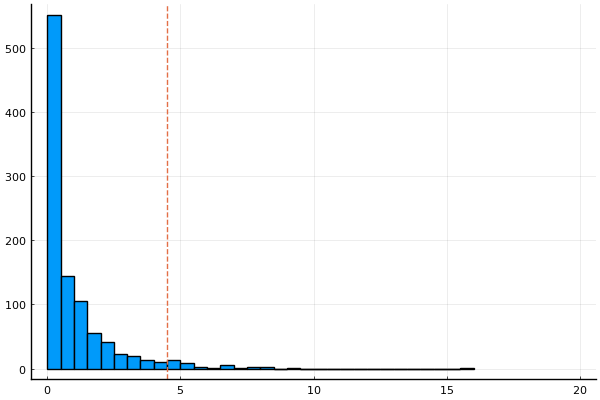

In [11]:
histogram(dd12, xlim=[0, 20], legend=false)
vline!([deltaD], linestyle=:dash)

In [12]:
sum(dd12 .>= deltaD)

37

In [13]:
p_value = sum(dd12 .>= deltaD) / length(dd12)

0.037

In [14]:
α = 0.05
quantile(dd12, 1-α)

3.9456503389490574

有意水準5%では上記の数値くらいまでの逸脱度の差は「よくある差」だと判断できる。

### 3.4.2 方法(2) カイ二乗分布を使った近似計算法

JuliaにRのようなANOVAは無さそうなので、コード例をそのままJuliaに移植することはできない。でもカイ二乗分布の累積分布関数を使ってp値を求めることはできる。

In [15]:
fit1 = glm(@formula(y ~ 1), d, Poisson(), LogLink())
fit2 = glm(@formula(y ~ x), d, Poisson(), LogLink())
dd12 = deviance(fit1) - deviance(fit2)
1 - cdf(Chisq(1), dd12)

0.03361969100898521